In [3]:
library(tidyverse)
library(gridExtra)
library(data.table)
library(ggthemes)
library(caret)
library(rpart)
library(ROCR)
library(rpart.plot)

In [6]:
library(cowplot)

Warning message:
"package 'cowplot' was built under R version 3.5.3"
Attaching package: 'cowplot'

The following object is masked from 'package:ggthemes':

    theme_map

The following object is masked from 'package:ggplot2':

    ggsave



In [7]:
## ggplot theme
theme <- theme(
    axis.text.y = element_blank(), axis.ticks.y = element_blank(),
    legend.position="none" 
)

In [8]:
## Load Data
data <- read.csv("C:/Users/HOME/Downloads/8 semester/IBM FINAL PROJECT/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Exploratory Data Analysis


In [9]:
data <- data %>%
mutate(
    # column was int but best to have it as logical
    SeniorCitizen = as.logical(SeniorCitizen)
)
str(data)

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w

This dataset contains 7043 observations with 21 variables

# Check for missing data
Next, we check how many NA records we have, per column.

In [10]:
data %>%
    summarise_all(
        funs(sum(is.na(.)))
    ) %>%
gather(ColumnTitle, NAs, customerID:Churn)

Warning message:
"funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

# Before:
funs(name = f(.)

# After: 
list(name = ~f(.))
This warning is displayed once per session."

ColumnTitle,NAs
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


There are 11 records with NA in 'Total Charges'. I suspect those are customers who have just signed up (tenure == 0), not having received yet a bill. Let's check

In [11]:
data %>%
select(
    customerID, tenure, TotalCharges
) %>%
filter(
    is.na(TotalCharges)
)

customerID,tenure,TotalCharges
4472-LVYGI,0,NA
3115-CZMZD,0,NA
5709-LVOEQ,0,NA
4367-NUYAO,0,NA
1371-DWPAZ,0,NA
7644-OMVMY,0,NA
3213-VVOLG,0,NA
2520-SGTTA,0,NA
2923-ARZLG,0,NA
4075-WKNIU,0,NA


Assumption is correct. We'll leave those values as null.


# Data analysis
EDA will start looking at how many people in this dataset churned (ended their service contract).

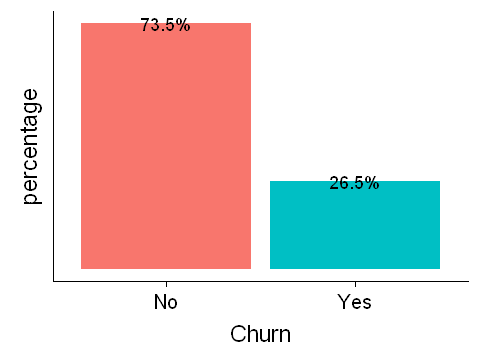

In [12]:
options(repr.plot.width = 4, repr.plot.height = 3)

data %>%
group_by(Churn) %>%
    summarize(
        n = n()
    ) %>%
    mutate(
        percentage = round(n / sum(n), 3),
        n = NULL
    ) %>%
ggplot(aes(x = Churn, y = percentage)) + geom_col(aes(fill = Churn)) +
theme +
geom_text(
        aes(x = Churn, y = percentage, label = paste(percentage*100, "%", sep = ""))
    )

26.5% of customers in this dataset have churned.

Next, I'll explore other columns with a function to output multiple graphs at once.

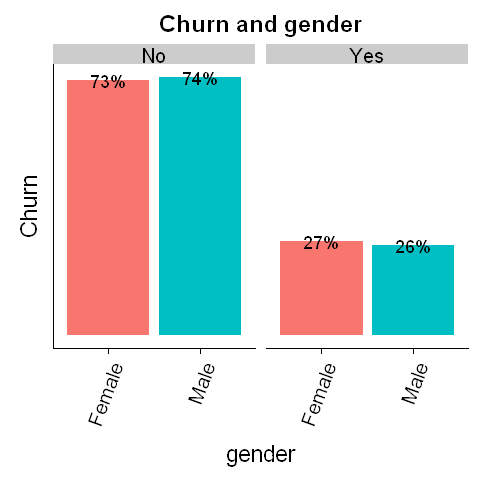

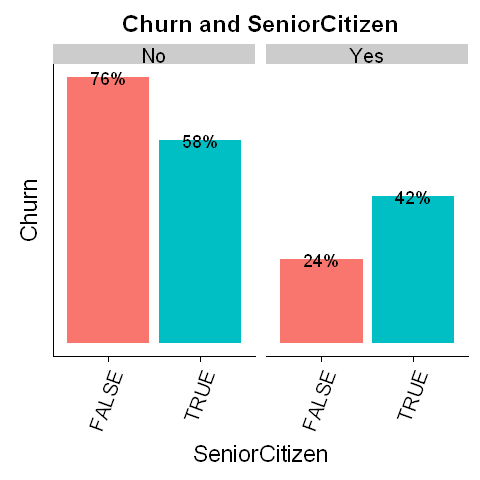

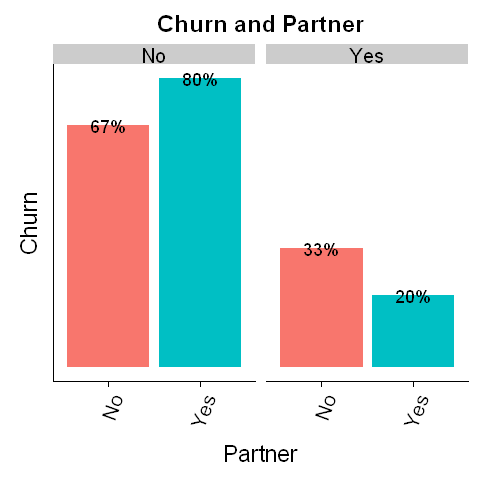

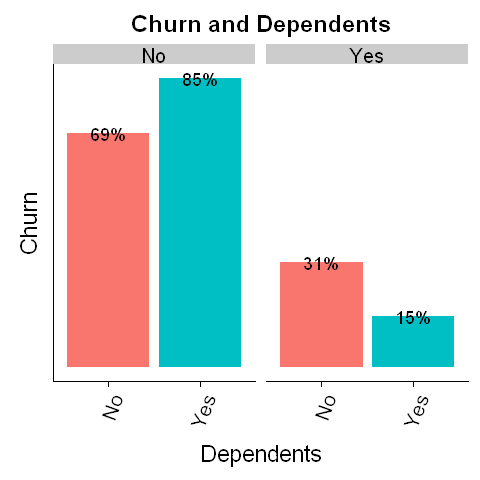

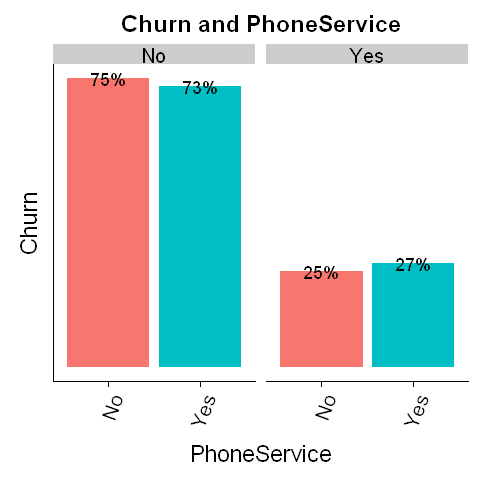

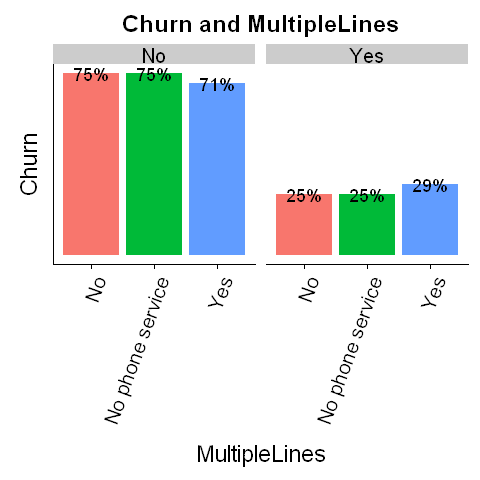

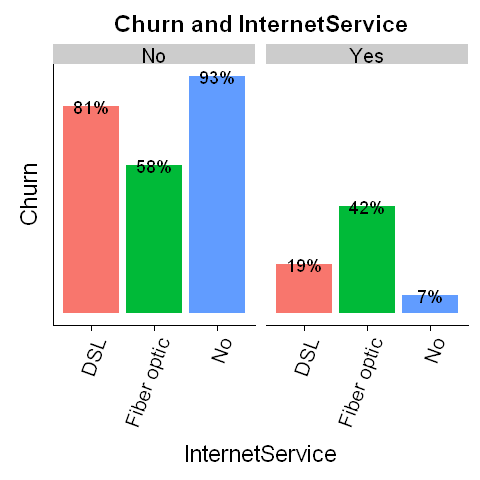

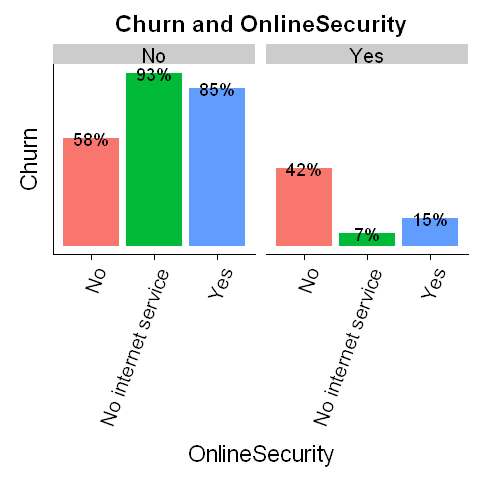

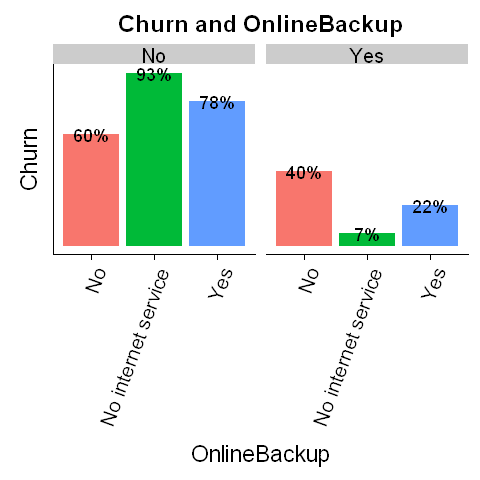

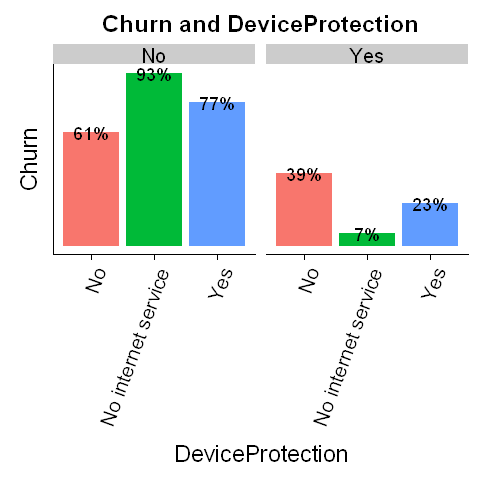

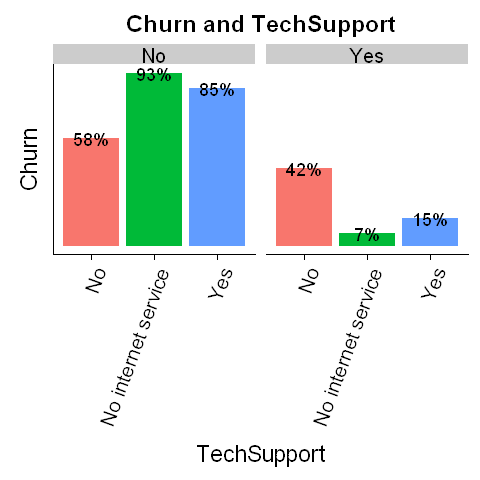

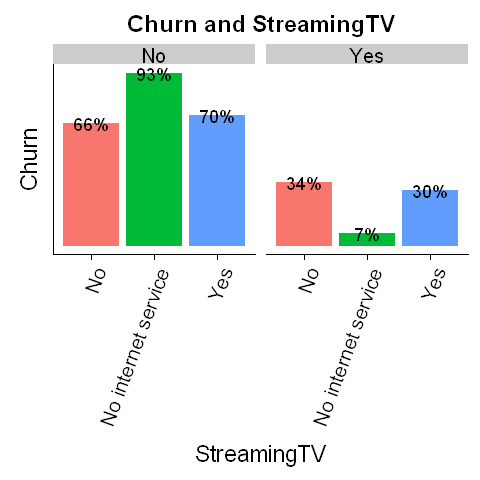

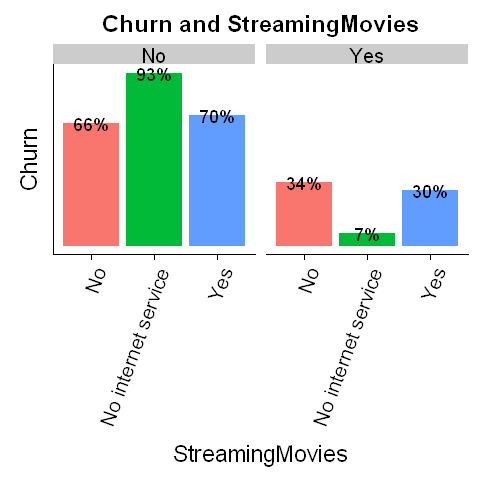

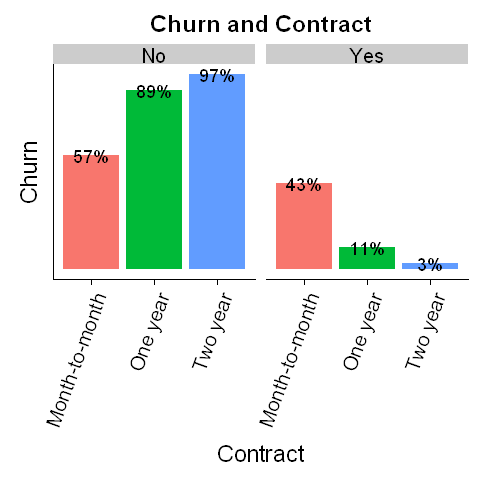

ERROR: Error in `[.data.frame`(x, r, vars, drop = drop): undefined columns selected


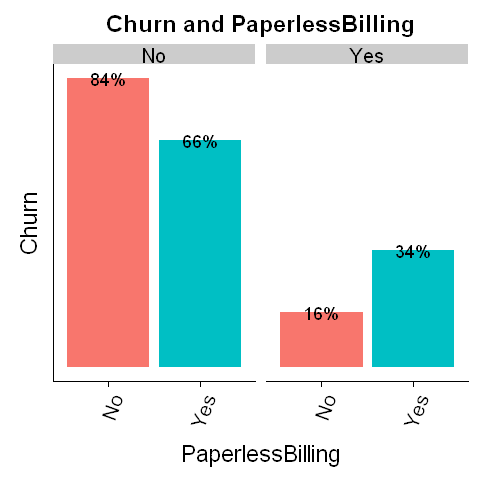

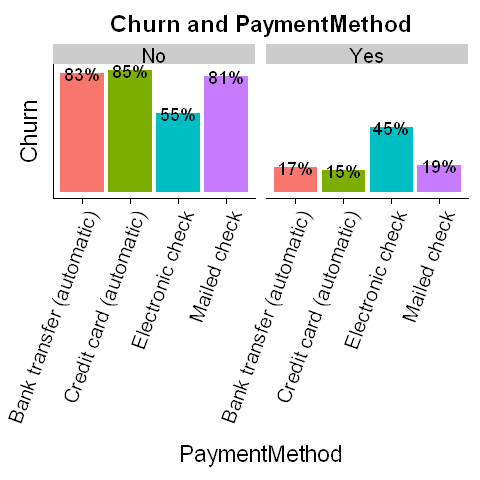

In [13]:
# Decrease graph size from standard
options(repr.plot.width = 4, repr.plot.height = 4)

# Function to generate graphs for factor variables and churn

## Extract columns to be analyzed
function_columns <- data %>%
    select(
        "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", 
        "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
        "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "Churn"
          )

## Function, goes through each column selected
for (i in 1:ncol(function_columns))
{
    # Get column names so dplyr group by works
    cname <- colnames(function_columns[c(i,17)])
    # Subset data frame by variable name selected
    a <- subset(
        function_columns, !is.na(function_columns[,i]) & function_columns[,i] != "",
                select = cname
    ) %>%
    # Create percentage statistics per variable
    group_by_at(vars(cname)) %>%
    summarize(
        n = n()
    ) %>%
    mutate(
        Percentage = round(n / sum(n), 2)
    )
    
    # Save plot in a variable so plots can be displayed sequentialy
    p <- ggplot(
        data = a, aes_string(
            x = colnames(a[1]), y = colnames(a[4]), fill = colnames(a[1])
        )
    ) +
    # Split each graph per Churn to see influence of variable
    facet_wrap("Churn") + 
    geom_bar(stat = "identity") +
    # Make graph a bit cleaner
    theme(
        axis.text.y = element_blank(), axis.ticks.y = element_blank(),
        axis.text.x = element_text(angle = 70, hjust = 1),
        legend.position="none"
    ) +
    geom_text(
        aes(y = Percentage, label = paste0(Percentage * 100,"%"))
    ) +
    labs(
        x = colnames(a[1]), y = "Churn", title = paste("Churn and", colnames(a[1]))
    )
    
    # Display graphs
    print(p)
    # Cleanup
    rm(cname, a, p)
}

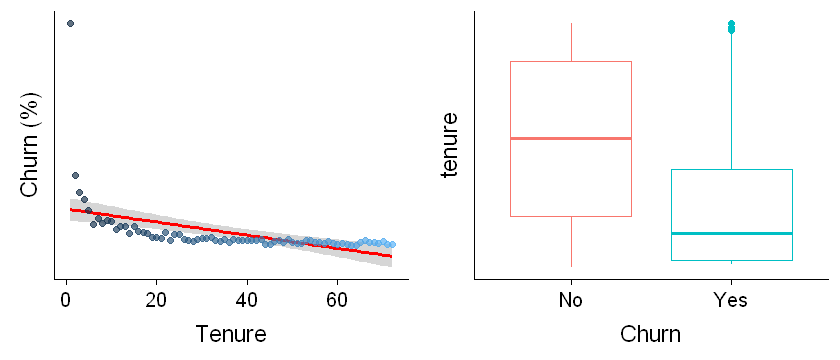

In [14]:
# Decrease graph size from standard
options(repr.plot.width = 7, repr.plot.height = 3)
plot_grid(
data %>%
    filter(Churn == "Yes") %>%
    group_by(tenure) %>%
    summarize(
        n = n()
    ) %>%
    mutate(
        Percentage = round(n / sum(n), 3)
    ) %>%
    # Create plot
    ggplot(
        aes(x = tenure, y = Percentage, color = tenure)
    ) +
    stat_smooth(method = "lm", col = "red") +
    geom_point(alpha = 2/3) +
    # Clean graph visual a bit
    theme +
    labs(
        x = "Tenure", y = "Churn (%)"
    ),

ggplot(
    data = data,
    aes(y = tenure, x = Churn, color = Churn)
    ) +
    theme +
    geom_boxplot()
, align = "h")

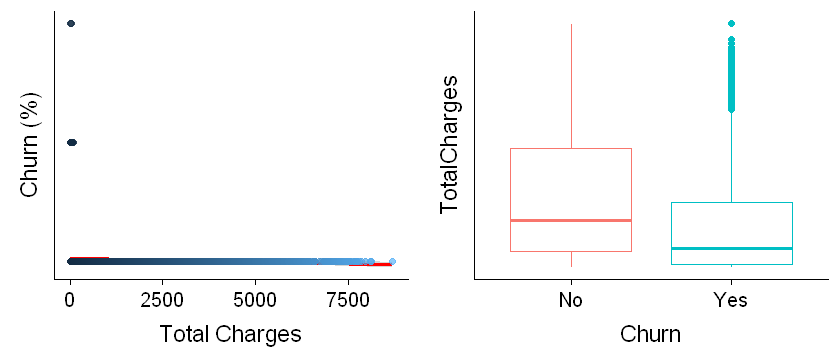

In [15]:
# Decrease graph size from standard
options(repr.plot.width = 7, repr.plot.height = 3)
plot_grid(
    
data %>%
    filter(Churn == "Yes") %>%
    group_by(TotalCharges) %>%
    summarize(
        n = n()
    ) %>%
    mutate(
        Percentage = round(n / sum(n), 3)
    ) %>%
    # Create plot
    ggplot(
        aes(x = TotalCharges, y = Percentage, color = TotalCharges)
    ) +
    stat_smooth(method = "lm", col = "red") +
    geom_point(alpha = 2/3) +
    # Clean graph visual a bit
    theme +
    labs(
        x = "Total Charges", y = "Churn (%)"
    ),

data %>%
    filter(is.na(TotalCharges) == FALSE) %>%
ggplot(
    aes(y = TotalCharges, x = Churn, color = Churn)
    ) +
    theme +
    geom_boxplot()
, align = "h")


# Prediction Models

### Data cleaning and preparation

### Removing columns we won't analyze

Customer ID isn't related to churn, so it is the first removed. From the above, gender, phone service, multiple lines, monthly charges and total charges will also be removed

In [17]:
# Remove columns we didn't see correlation from above
data.model <- data %>%
    select(
        -customerID, -gender,-PhoneService, -MultipleLines, -MonthlyCharges, -TotalCharges 
    )

In [18]:
# Set seed
set.seed(123)

# Split data, 75% distribution of churn for training
train.index <- createDataPartition(
    y = data.model$Churn, p = 0.75, list = FALSE
)

train <- data.model[train.index,]
test <- data.model[-train.index,]

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1219  313
       Yes   74  154
                                        
               Accuracy : 0.7801        
                 95% CI : (0.76, 0.7993)
    No Information Rate : 0.7347        
    P-Value [Acc > NIR] : 6.119e-06     
                                        
                  Kappa : 0.3258        
                                        
 Mcnemar's Test P-Value : < 2.2e-16     
                                        
            Sensitivity : 0.9428        
            Specificity : 0.3298        
         Pos Pred Value : 0.7957        
         Neg Pred Value : 0.6754        
             Prevalence : 0.7347        
         Detection Rate : 0.6926        
   Detection Prevalence : 0.8705        
      Balanced Accuracy : 0.6363        
                                        
       'Positive' Class : No            
                                        

[1] "AUC Value is: 0.785685067510611"

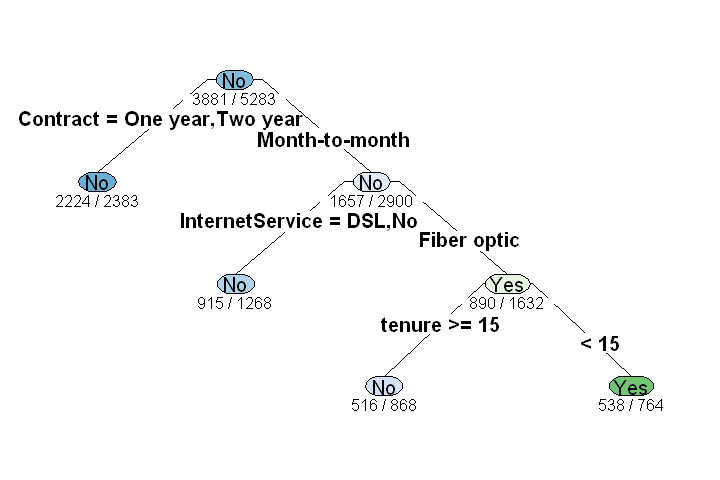

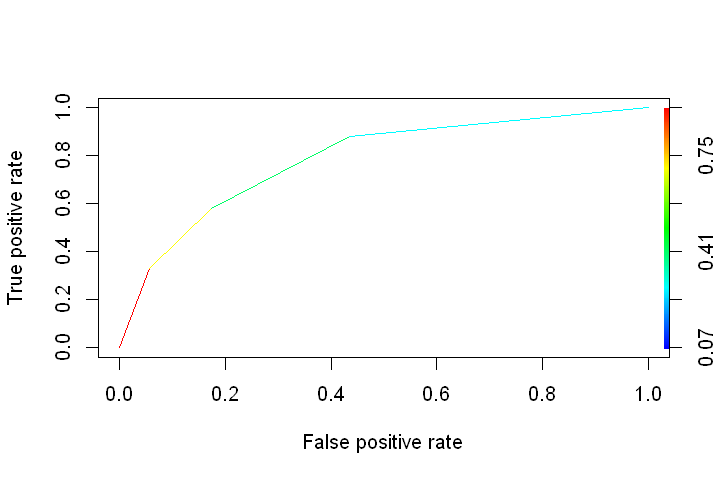

In [19]:
options(repr.plot.width = 6, repr.plot.height = 4)

# Fit model
tree.fit <- rpart(
    Churn ~ ., 
    data = train, 
    method = "class"
)

# Graph of tree
rpart.plot(
    tree.fit,
    type = 4,
    extra = 2,
    under = TRUE,
    fallen.leaves = F
)

# Prediction, classification
tree.pred <- predict(
    tree.fit,
    test, 
    type = "class"
)

confusionMatrix(
    tree.pred,test$Churn
)

# Prediction, probability
tree.pred.prob <- predict(
    tree.fit, 
    test, 
    type = "prob"
)
tree.pred.prob.val <- prediction(
    tree.pred.prob[,2],
    test$Churn
)
tree.pred.prob.perf <- performance(
    tree.pred.prob.val,
    "auc"
)

# print AUC value
paste(
    "AUC Value is:", 
    as.numeric(performance(
        tree.pred.prob.val, 
        "auc"
    )@y.values
              )
)
# plots the ROC curve with colors where the splits are.
plot(performance(tree.pred.prob.val, "tpr", "fpr"), colorize = TRUE)

The decision tree above has accuracy of 0.7801. The decision tree plot above shows churn is predicted if the contract is month-to-month, client ordered fiber optic and has a contract shorter then 14 months. AUC curve isn't very smooth; a probability of around 0.4 gives the best true positive rate (0.8) but at that level the false positve rate isn't very good (around 0.45).

### Random Forest
Next we grow several trees with random forest. Let's see the results. 

In [ ]:
rf.fit  <- train(Churn ~ . , method = "rf", data = train, importance = TRUE)

rf.pred <- predict(rf.fit, test)

In [ ]:
confusionMatrix(rf.pred, test$Churn)
#performance(rf.pred, measure = "auc")@y.values[[1]]

# Prediction, probability
rf.pred.prob <- predict(
    rf.fit, 
    test, 
    type = "prob"
)
rf.pred.prob.val <- prediction(
    rf.pred.prob[,2],
    test$Churn
)
rf.pred.prob.perf <- performance(
    rf.pred.prob.val,
    "auc"
)

# print AUC value
paste(
    "AUC Value is:", 
    as.numeric(performance(
        rf.pred.prob.val, 
        "auc"
    )@y.values
              )
)
# plots the ROC curve with colors where the splits are.
plot(performance(rf.pred.prob.val, "tpr", "fpr"), colorize = TRUE)


Random forest's AUC curve is smoother, AUC value is higher. A lower probability cutoff (around 0.2) has a good true positive rate (0.7) and a low false positive (0.2).

### Conclusion
